In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
df=pd.read_csv('booksie.csv')
df.head()

,1668410316669,198.40000915527344,386.6000061035156
0,1668410316936,200.000000,386.600006
1,1668410316944,202.400009,386.600006
2,1668410316958,204.000000,386.600006
3,1668410316974,214.400009,386.600006
4,1668410316991,225.600006,385.800018


In [49]:
data=df.to_numpy()

In [50]:
data1=data[:,0]

In [51]:
seperations=[0]
for i in range(len(data1)-1):
    if (data1[i+1]-data1[i])>=565:
        seperations.append(i)
    else:
        pass

In [52]:
segments=[]
for i in range(len(seperations)-1):
    segments.append(data[(seperations[i]+5):(seperations[i+1]-5)])

In [112]:
def dx(i): return dat.x[i]-dat.x[i-1]
def dy(i): return dat.y[i]-dat.y[i-1]
def dt(i): return dat.time[i]-dat.time[i-1]
def theta(i):
    feature=0
    feature=math.atan2(dx(i+1)*dy(i)-dx(i)*dy(i+1),dx(i+1)*dx(i)+dy(i+1)*dy(i))
    return feature
def sigma(start, end, fun): return sum([fun(i) for i in range(start, end)])
def rf1(d): return (d.x[2]-d.x[0])/math.sqrt((d.y[2]-d.y[0])**2+(d.x[2]-d.x[0])**2)
def rf2(d): return (d.y[2]-d.y[0])/math.sqrt((d.y[2]-d.y[0])**2+(d.x[2]-d.x[0])**2)
def rf3(d): return math.sqrt((max(d.y)-min(d.y))**2+(max(d.x)-min(d.x))**2)
def rf4(d): return math.atan2(max(d.y)-min(d.y), max(d.x)-min(d.x))
def rf5(d): return math.sqrt((d.x[len(d)-1]-d.x[0])**2+(d.y[len(d)-1]-d.y[0])**2)
def rf6(d): return (d.x[len(d)-1]-d.x[0])/rf5(d)
def rf7(d): return (d.y[len(d)-1]-d.y[0])/rf5(d)
def rf8(d): return sigma(1, len(d), lambda i: math.sqrt(dx(i)**2+dy(i)**2))
def rf9(d): return sigma(1, len(d)-1, theta)
def rf10(d): return sigma(1, len(d)-1, lambda i: abs(theta(i)))
def rf11(d): return sigma(1, len(d)-1, lambda i: theta(i)**2)
def rf12(d): return max([(dx(i)**2+dy(i)**2)/dt(i)**2 if dt(i) > 0 else 0 for i in range(1, len(d))])
def rf13(d): return d.time[len(d)-1]-d.time[0]

In [113]:
df_list=[]
for i in segments:
    df_list.append(pd.DataFrame(i,columns=['time','x','y']))

In [114]:
stroke_features=[]
for i in range(len(df_list)):
    temp=[]
    dat=df_list[i]
    f1=rf1(df_list[i])
    f2=rf2(df_list[i])
    f3=rf3(df_list[i])
    f4=rf4(df_list[i])
    f5=rf5(df_list[i])
    f6=rf6(df_list[i])
    f7=rf7(df_list[i])
    f8=rf8(df_list[i])
    f9=rf9(df_list[i])
    f10=rf10(df_list[i])
    f11=rf11(df_list[i])
    f12=rf12(df_list[i])
    f13=rf13(df_list[i])
    temp+=[f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13]
    stroke_features.append(temp)

In [115]:
df=pd.DataFrame(stroke_features,columns=['rf1','rf2','rf3','rf4','rf5','rf6','rf7','rf8','rf9','rf10','rf11','rf12','rf13'])

In [116]:
df

,rf1,rf2,rf3,rf4,rf5,rf6,rf7,rf8,rf9,rf10,rf11,rf12,rf13
0,0.998581,-0.053258,747.323786,0.018199,747.210734,0.999986,0.005353,749.006582,-3.332174e-02,2.371219,0.343934,5.104505,600.0
1,0.000000,1.000000,104.799988,1.570796,104.799988,0.000000,1.000000,104.799988,0.000000e+00,0.000000,0.000000,0.318893,517.0
2,-0.980581,-0.196113,144.481383,0.647931,12.026637,0.997785,0.066519,328.435844,6.746829e+00,57.294403,44.911261,0.179378,2683.0
3,0.000000,1.000000,165.321604,0.692880,2.884414,0.832045,0.554708,538.652046,-1.570796e+00,49.660168,43.103323,0.540344,4832.0
4,1.000000,0.000000,252.811441,0.009493,252.801315,0.999995,-0.003164,253.049531,-1.418978e-01,0.819793,0.098347,0.422502,967.0
5,0.000000,-1.000000,186.571589,1.527904,184.973067,-0.043250,-0.999064,189.310349,-3.141593e+00,4.763383,10.204497,0.221453,1096.0
6,1.000000,0.000000,213.330214,0.296844,5.366549,-0.447219,-0.894424,455.398445,3.141593e+00,36.844652,23.475691,0.184999,3267.0
7,0.000000,1.000000,214.271587,0.626326,14.751264,0.216931,-0.976187,547.435910,6.283185e+00,54.392173,57.374280,0.252500,3982.0
8,-1.000000,0.000000,146.476498,0.870464,1.788832,0.894425,0.447219,347.515454,6.283185e+00,53.137295,43.148261,0.112500,3664.0
9,1.000000,0.000000,20.800049,0.000000,20.800049,1.000000,0.000000,20.800049,0.000000e+00,0.000000,0.000000,0.045511,199.0


list

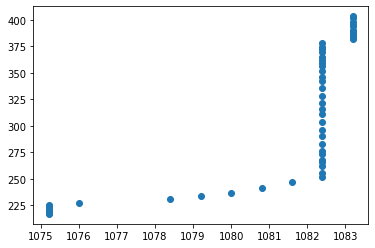

In [134]:
a=segments[5]
plt.scatter(a[:,1],a[:,2])
type(segments)

# Single Link Euclidean Distance between strokes

In [136]:
import math
def distance(u,v):
    minimum=[]
    min_d=[]
    u=np.array(u)
    v=np.array(v)
    u=np.delete(u,0,1)
    v=np.delete(v,0,1)
    for i in range(len(u)):
        for j in range(len(v)):
            d=math.dist(u[i],v[j])
            minimum.append(d)
        minimum.sort()
        minum=minimum[0]
        min_d.append(minum)
    min_d.sort()
    return min_d[0]
composite=[]
for i in range(len(segments)):
    un=segments[i]
    distarr=[]
    dist_index=[]
    for j in range(len(segments)):
        if i==j:
            pass
        else:
            vn=segments[j]
            sldist=distance(un,vn)
            distarr.append(sldist)
            dist_index.append(j)
    matrix=np.array([dist_index,distarr])
    composite.append(matrix)

In [147]:
c=np.array(composite)
c

array([[[  1.        ,   2.        ,   3.        ,   4.        ,
           5.        ,   6.        ,   7.        ,   8.        ,
           9.        ,  10.        ,  11.        ,  12.        ,
          13.        ,  14.        ,  15.        ],
        [  9.63328073, 137.6000061 ,  21.59997559, 156.00205136,
          92.77930804, 170.3999939 , 218.40145905, 224.85122725,
         288.05445408, 276.96297202, 280.60049589, 252.48083324,
         262.67424845, 255.00808575, 246.30647677]],

       [[  0.        ,   2.        ,   3.        ,   4.        ,
           5.        ,   6.        ,   7.        ,   8.        ,
           9.        ,  10.        ,  11.        ,  12.        ,
          13.        ,  14.        ,  15.        ],
        [  9.63328073,  23.21380078, 594.3999939 , 728.97562832,
         659.01751825, 561.83981454, 252.53909157, 290.15419462,
         439.8872448 , 517.47385689, 617.46321733, 661.87616501,
         240.96343232, 162.73659609, 133.04556387]],

       [

# Distinguishing between line and non-line segments

In [138]:
line_arr=[]
obj_arr=[]
for i in range(len(stroke_features)):
    r=stroke_features[i]
    end_to_end=r[4]
    length=r[7]
    if end_to_end>=0.90*length:
        line_arr.append(i)
    else:
        obj_arr.append(i)
        pass
line_arr,obj_arr

([0, 1, 4, 5, 9, 10, 11, 12, 13, 14, 15], [2, 3, 6, 7, 8])

In [139]:
dashed=[]
for i in line_arr:
    r=stroke_features[i]
    length=r[7]
    if length<=50:
        dashed.append(i)
dashed

[9, 10, 11, 12, 13, 14, 15]

# Feature Engineering for circle within square(IC Control Loop)

In [110]:
minmax=[]
for i in obj_arr:
    segs=segments[i]
    minx=min(segs[:,1])
    maxx=max(segs[:,1])
    miny=min(segs[:,2])
    maxy=max(segs[:,2])
    minmax.extend([[minx,maxx,miny,maxy]])
for i in range(len(minmax)):
    

[[364.8000183105469, 480.0, 157.80003356933594, 245.0],
 [1012.0, 1139.2000732421875, 341.0, 446.6000671386719],
 [976.7999877929688, 1180.800048828125, 157.80003356933594, 220.1999969482422],
 [647.2000122070312, 820.7999877929688, 41.0, 166.60000610351562],
 [676.0, 770.4000244140625, 50.600006103515625, 162.60000610351562]]

# Determining Association through Euclidean Distance

In [157]:
for i in range(len(c)):
    a=c[i]
    xcalibre=np.argsort(a[1])
    xsorted=np.sort(a[1])
    xsorted=xsorted[xsorted<80]
    xcalibre=xcalibre[:len(xsorted)]

In [158]:
xsorted,xcalibre

(array([22.40000916, 36.70423101]), array([ 2, 14], dtype=int64))